# Exp 4

## Prepare Cleaned Datasets for Exp_004

In [1]:
import re
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import kagglehub
import os

# 1. Define a Python function `clean_response_text`
def clean_response_text(text):
    if not isinstance(text, str):
        return ""
    # Remove '### Instruction:' and everything that follows until '### Response:'
    # or end of string
    cleaned_text = re.sub(r"###\s*Instruction:.*?###\s*Response:", "", text, flags=re.DOTALL)
    # Remove any standalone '### Instruction:' or '### Response:'
    cleaned_text = re.sub(r"###\s*Instruction:\n*(.*)", r"\1", cleaned_text, flags=re.DOTALL)
    cleaned_text = re.sub(r"###\s*Response:\n*(.*)", r"\1", cleaned_text, flags=re.DOTALL)
    # Remove any remaining '###' delimiters (e.g., from partial generations or quirks)
    cleaned_text = re.sub(r"###+", "", cleaned_text)
    # Remove multiple consecutive newlines and then strip leading/trailing whitespace
    cleaned_text = re.sub(r'[\r\n]+', '\n', cleaned_text).strip()
    return cleaned_text

print("Defined `clean_response_text` function.")

# 2. Load the `intronhealth/afrimedqa_v2` dataset
afrimedqa_dataset = load_dataset('intronhealth/afrimedqa_v2')
afrimedqa_df = afrimedqa_dataset['train'].to_pandas()
print(f"Loaded intronhealth/afrimedqa_v2 dataset. Shape: {afrimedqa_df.shape}")

# 3. Download the `MedQuAD` dataset files and load `medquad.csv`
medquad_download_path = kagglehub.dataset_download("pythonafroz/medquad-medical-question-answer-for-ai-research")
medquad_csv_path = os.path.join(medquad_download_path, 'medquad.csv')
medquad_df = pd.read_csv(medquad_csv_path)
print(f"Loaded MedQuAD dataset. Shape: {medquad_df.shape}")

print("Datasets loaded successfully, proceeding to cleaning and verification.")

Defined `clean_response_text` function.


README.md:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

afri_med_qa_15k_v2.4_phase_2_15275.csv:   0%|          | 0.00/8.64M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15275 [00:00<?, ? examples/s]

Loaded intronhealth/afrimedqa_v2 dataset. Shape: (15275, 29)


100%|██████████| 4.95M/4.95M [00:00<00:00, 78.2MB/s]

Extracting files...


Loaded MedQuAD dataset. Shape: (16412, 4)
Datasets loaded successfully, proceeding to cleaning and verification.


In [2]:
import re
import pandas as pd # Already imported, but kept for clarity

# 4. Apply the `clean_response_text` function to the 'answer' column of `medquad_df`
medquad_df['cleaned_answer'] = medquad_df['answer'].apply(clean_response_text)

# Apply the `clean_response_text` function to the 'answer_rationale' column of `afrimedqa_df`.
# Handle potential None values by filling them with empty strings before cleaning.
afrimedqa_df['cleaned_answer_rationale'] = afrimedqa_df['answer_rationale'].fillna('').apply(clean_response_text)

print("Applied `clean_response_text` function to 'medquad_df' and 'afrimedqa_df'.")
print(f"New columns added to medquad_df: {'cleaned_answer' in medquad_df.columns}")
print(f"New columns added to afrimedqa_df: {'cleaned_answer_rationale' in afrimedqa_df.columns}")

Applied `clean_response_text` function to 'medquad_df' and 'afrimedqa_df'.
New columns added to medquad_df: True
New columns added to afrimedqa_df: True


In [3]:
import pandas as pd # Already imported, but kept for clarity

# 5. Print 5 random examples for medquad_df to verify cleaning
print("\n--- MedQuAD: Raw vs. Cleaned Answer Examples ---")
for i in range(5):
    # Sample a random row
    sample_row = medquad_df.sample(n=1, random_state=42 + i) # Use different seed for each sample
    original_answer = sample_row['answer'].iloc[0]
    cleaned_answer = sample_row['cleaned_answer'].iloc[0]

    print(f"\nExample {i+1}:")
    print(f"  Raw Answer:     {original_answer[:300]}...")
    print(f"  Cleaned Answer: {cleaned_answer[:300]}...")
    print("---------------------------------------------------")

# 5. Print 5 random examples for afrimedqa_df to verify cleaning
print("\n--- AfrimedQA_v2: Raw vs. Cleaned Answer Rationale Examples ---")
for i in range(5):
    # Sample a random row
    sample_row = afrimedqa_df.sample(n=1, random_state=42 + i) # Use different seed for each sample
    original_rationale = sample_row['answer_rationale'].iloc[0] # This can be None
    cleaned_rationale = sample_row['cleaned_answer_rationale'].iloc[0]

    print(f"\nExample {i+1}:")
    print(f"  Raw Rationale:     {str(original_rationale)[:300]}...") # Convert to string for safety
    print(f"  Cleaned Rationale: {cleaned_rationale[:300]}...")
    print("---------------------------------------------------")


--- MedQuAD: Raw vs. Cleaned Answer Examples ---

Example 1:
  Raw Answer:     LBSL is caused by mutations in the DARS2 gene, which provides instructions for making an enzyme called mitochondrial aspartyl-tRNA synthetase. This enzyme is important in the production (synthesis) of proteins in cellular structures called mitochondria, the energy-producing centers in cells. While m...
  Cleaned Answer: LBSL is caused by mutations in the DARS2 gene, which provides instructions for making an enzyme called mitochondrial aspartyl-tRNA synthetase. This enzyme is important in the production (synthesis) of proteins in cellular structures called mitochondria, the energy-producing centers in cells. While m...
---------------------------------------------------

Example 2:
  Raw Answer:     NINDS conducts and supports research on disorders of the spinal cord such as spinal cord infarction, aimed at learning more about these disorders and finding ways to prevent and treat them....
  Cleaned Answer: N

In [4]:
from datasets import Dataset, DatasetDict, concatenate_datasets

# 6. Convert the cleaned `medquad_df` into a Hugging Face `Dataset`
# Use 'question' as 'instruction' and 'cleaned_answer' as 'response'
medquad_qa_dataset = Dataset.from_pandas(medquad_df[['question', 'cleaned_answer']].rename(columns={'question': 'instruction', 'cleaned_answer': 'response'}))
print("MedQuAD cleaned dataset converted to unified QA format successfully:")
print(medquad_qa_dataset)

# 7. Convert the cleaned `afrimedqa_df` into a Hugging Face `Dataset`
# Use 'question' as 'instruction' and 'cleaned_answer_rationale' as 'response'
afrimedqa_qa_dataset = Dataset.from_pandas(afrimedqa_df[['question', 'cleaned_answer_rationale']].rename(columns={'question': 'instruction', 'cleaned_answer_rationale': 'response'}))
print("AfrimedQA_v2 cleaned dataset converted to unified QA format successfully:")
print(afrimedqa_qa_dataset)

# 8. Concatenate `medquad_qa_dataset` and `afrimedqa_qa_dataset` into a single `unified_dataset`
unified_dataset_cleaned = concatenate_datasets([medquad_qa_dataset, afrimedqa_qa_dataset])
print("\nUnified cleaned dataset created successfully:")
print(unified_dataset_cleaned)

# 9. Filter `unified_dataset` to remove any entries where the 'instruction' or 'response' are empty or contain only whitespace.
initial_num_rows_cleaned = len(unified_dataset_cleaned)
unified_dataset_cleaned = unified_dataset_cleaned.filter(lambda example: example['instruction'].strip() != '' and example['response'].strip() != '')
cleaned_num_rows_final = len(unified_dataset_cleaned)

print(f"\nRemoved {initial_num_rows_cleaned - cleaned_num_rows_final} entries due to empty instruction or response after cleaning.")
print(f"Unified dataset after final cleaning: {unified_dataset_cleaned}")

# 10. Split the cleaned and unified `Dataset` into training, validation, and test sets
# Shuffle with a fixed seed (e.g., 42) for reproducibility
shuffled_dataset_cleaned = unified_dataset_cleaned.shuffle(seed=42)

train_test_split_cleaned = shuffled_dataset_cleaned.train_test_split(test_size=0.2, seed=42)
val_test_split_cleaned = train_test_split_cleaned['test'].train_test_split(test_size=0.5, seed=42)

train_val_test_dataset_cleaned = DatasetDict({
    'train': train_test_split_cleaned['train'],
    'validation': val_test_split_cleaned['train'],
    'test': val_test_split_cleaned['test']
})

print("\nCleaned unified dataset split into training, validation, and test sets successfully:")
print(train_val_test_dataset_cleaned)

print("\nSample from cleaned training set (first example):")
print(train_val_test_dataset_cleaned['train'][0])

MedQuAD cleaned dataset converted to unified QA format successfully:
Dataset({
    features: ['instruction', 'response'],
    num_rows: 16412
})
AfrimedQA_v2 cleaned dataset converted to unified QA format successfully:
Dataset({
    features: ['instruction', 'response'],
    num_rows: 15275
})

Unified cleaned dataset created successfully:
Dataset({
    features: ['instruction', 'response'],
    num_rows: 31687
})


Filter:   0%|          | 0/31687 [00:00<?, ? examples/s]


Removed 13570 entries due to empty instruction or response after cleaning.
Unified dataset after final cleaning: Dataset({
    features: ['instruction', 'response'],
    num_rows: 18117
})

Cleaned unified dataset split into training, validation, and test sets successfully:
DatasetDict({
    train: Dataset({
        features: ['instruction', 'response'],
        num_rows: 14493
    })
    validation: Dataset({
        features: ['instruction', 'response'],
        num_rows: 1812
    })
    test: Dataset({
        features: ['instruction', 'response'],
        num_rows: 1812
    })
})

Sample from cleaned training set (first example):
{'instruction': 'What are the treatments for Parasites - Lymphatic Filariasis ?', 'response': 'Patients currently infected with the parasite\n    \nDiethylcarbamazine (DEC) is the drug of choice in the United States. The drug kills the microfilaria and some of the adult worms. DEC has been used world-wide for more than 50 years. Because this infection is 

In [6]:
from transformers import AutoTokenizer
import torch

# Assuming train_val_test_dataset_cleaned is available from previous steps (cell 64f9affd)

# 1. Load the AutoTokenizer for TinyLlama/TinyLlama-1.1B-Chat-v1.0
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 2. Add a padding token if it doesn't exist and set padding_side
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Or tokenizer.eos_token
tokenizer.padding_side = 'left' # Set padding side to 'left' for decoder-only models during generation

print(f"Tokenizer for {model_name} loaded successfully. Padding token: {tokenizer.pad_token}, Padding side: {tokenizer.padding_side}")

# 3. Define a Python function, `prepare_for_training`
def prepare_for_training(examples, tokenizer, max_length=512):
    # This function is now designed to handle a batch of examples.
    # `examples` will be a dictionary where values are lists (e.g., {'instruction': ['instr1', 'instr2'], 'response': ['resp1', 'resp2']})

    batch_input_ids = []
    batch_attention_mask = []
    batch_labels = []

    for instruction, response in zip(examples['instruction'], examples['response']):
        full_prompt = f"""### Instruction:\n{instruction}\n\n### Response:\n{response}"""
        instruction_only_prompt = f"""### Instruction:\n{instruction}\n\n### Response:"""

        # Tokenize the full prompt string for this single example
        tokenized_full_prompt = tokenizer(
            full_prompt,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors="pt"
        )

        # Tokenize only the instruction part for this single example
        tokenized_instruction_only = tokenizer(
            instruction_only_prompt,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors="pt"
        )

        # Create labels by copying input_ids
        labels = tokenized_full_prompt['input_ids'].clone()

        # Mask out the tokens corresponding to the instruction part
        # Ensure it's a 1D tensor before calculating sum
        instruction_len_unpadded = (tokenized_instruction_only['input_ids'][0] != tokenizer.pad_token_id).sum().item()
        labels[0, :instruction_len_unpadded] = -100

        # Append the results for this example to the batch lists
        batch_input_ids.append(tokenized_full_prompt['input_ids'][0].tolist())
        batch_attention_mask.append(tokenized_full_prompt['attention_mask'][0].tolist())
        batch_labels.append(labels[0].tolist())

    # Return a dictionary where each value is a list of results for the batch
    return {
        'input_ids': batch_input_ids,
        'attention_mask': batch_attention_mask,
        'labels': batch_labels
    }

# 4. Apply this `prepare_for_training` function to all splits
print("Applying `prepare_for_training` function to dataset splits...")
tokenized_dataset_cleaned = train_val_test_dataset_cleaned.map(
    lambda examples: prepare_for_training(examples, tokenizer, max_length=512),
    batched=True,
    remove_columns=['instruction', 'response'] # Remove original text columns after tokenization
)

print("Dataset splits tokenized and prepared for training with label shifting.")
print("Sample from tokenized_dataset_cleaned (train split, first example): ")
print(tokenized_dataset_cleaned['train'][0].keys())
print(f"Length of input_ids: {len(tokenized_dataset_cleaned['train'][0]['input_ids'])}")
print(f"Length of labels: {len(tokenized_dataset_cleaned['train'][0]['labels'])}")
print("First 20 labels (should show -100 for instruction part):")
print(tokenized_dataset_cleaned['train'][0]['labels'][:20])

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Tokenizer for TinyLlama/TinyLlama-1.1B-Chat-v1.0 loaded successfully. Padding token: </s>, Padding side: left
Applying `prepare_for_training` function to dataset splits...


Map:   0%|          | 0/14493 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Dataset splits tokenized and prepared for training with label shifting.
Sample from tokenized_dataset_cleaned (train split, first example): 
dict_keys(['input_ids', 'attention_mask', 'labels'])
Length of input_ids: 512
Length of labels: 512
First 20 labels (should show -100 for instruction part):
[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]


## Load Base Model and PEFT Setup for Exp_004


In [7]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType

# 1. Define the base model name
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for Exp_004 model loading: {device}")

# 2. Check if CUDA is available and instantiate BitsAndBytesConfig for 4-bit quantization
model = None
quantization_config = None

if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load base model with 4-bit quantization for Exp_004.")
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=quantization_config,
            dtype=torch.bfloat16, # Use bfloat16 for quantized model on CUDA
            device_map="auto"
        )
        print("Base model loaded successfully with 4-bit quantization for Exp_004.")
    except Exception as e:
        print(f"Warning: 4-bit quantization failed during Exp_004 model load ({e}). Falling back to loading base model in full bfloat16 precision.")
        # If 4-bit fails, load without quantization, but still use bfloat16 if CUDA is available
        model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            dtype=torch.bfloat16,
            device_map="auto"
        )
else:
    print("CUDA not available. Loading base model in full float32 precision for Exp_004.")
    model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        dtype=torch.float32,
        device_map="auto"
    )

# 3. Define the target_modules for LoRA
target_modules = ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

# 4. Instantiate LoraConfig
lora_config = LoraConfig(
    r=8,  # LoRA attention dimension
    lora_alpha=16, # Alpha parameter for LoRA scaling
    target_modules=target_modules, # Modules to apply LoRA to
    lora_dropout=0.05, # Dropout probability for LoRA layers
    bias="none", # Bias type for LoRA layers
    task_type=TaskType.CAUSAL_LM # Task type for causal language modeling
)

# 5. Apply the LoRA configuration to the base model
peft_model = get_peft_model(model, lora_config)

# 6. Print the trainable parameter summary
print("\nPEFT model summary for Exp_004:")
peft_model.print_trainable_parameters()

print("\nBase model and PEFT setup configured successfully for Exp_004.")

Using device for Exp_004 model loading: cuda


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


PEFT model summary for Exp_004:
trainable params: 6,307,840 || all params: 1,106,356,224 || trainable%: 0.5701

Base model and PEFT setup configured successfully for Exp_004.


## Execute Fine-tuning Experiment 4 (Exp_004)


In [10]:
import os
import time
import torch
import json
import pandas as pd
from google.colab import drive
import huggingface_hub # Import huggingface_hub for login

# Install bitsandbytes for 4-bit quantization if not already installed
# This addresses the 'No module named 'bitsandbytes'' warning
!pip install -qqq bitsandbytes

# Re-import necessary libraries if not already in current kernel state
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
)
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import kagglehub

# 1. Ensure Google Drive is mounted for persistent checkpoint storage
drive.mount('/content/drive', force_remount=True)

# Log in to the Hugging Face Hub if necessary (will prompt for token if not logged in)
huggingface_hub.login()

# --- Re-create `tokenizer` and `tokenized_dataset_cleaned` if not available --- #
# This ensures the cell is self-contained if run out of order

# Load the tokenizer (from cell af1d0476)
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Or tokenizer.eos_token
tokenizer.padding_side = 'left' # Set padding side to 'left' for decoder-only models during generation

# Re-define `clean_response_text` function (from cell e49dd804)
def clean_response_text(text):
    if not isinstance(text, str):
        return ""
    cleaned_text = re.sub(r"###\s*Instruction:.*?###\s*Response:", "", text, flags=re.DOTALL)
    cleaned_text = re.sub(r"###\s*Instruction:\n*(.*)", r"\1", cleaned_text, flags=re.DOTALL)
    cleaned_text = re.sub(r"###\s*Response:\n*(.*)", r"\1", cleaned_text, flags=re.DOTALL)
    cleaned_text = re.sub(r"###+", "", cleaned_text)
    cleaned_text = re.sub(r'[\r\n]+', '\n', cleaned_text).strip()
    return cleaned_text

# Load and clean datasets (from cells e49dd804, c08853ca, 64f9affd)
# Load `intronhealth/afrimedqa_v2`
afrimedqa_dataset = load_dataset('intronhealth/afrimedqa_v2')
afrimedqa_df_temp = afrimedqa_dataset['train'].to_pandas()
afrimedqa_df_temp['cleaned_answer_rationale'] = afrimedqa_df_temp['answer_rationale'].fillna('').apply(clean_response_text)

# Download `MedQuAD` dataset files and load `medquad.csv`
medquad_download_path = kagglehub.dataset_download("pythonafroz/medquad-medical-question-answer-for-ai-research")
medquad_csv_path = os.path.join(medquad_download_path, 'medquad.csv')
medquad_df_temp = pd.read_csv(medquad_csv_path)
medquad_df_temp['cleaned_answer'] = medquad_df_temp['answer'].apply(clean_response_text)

# Convert to unified QA format and concatenate
medquad_qa_dataset_temp = Dataset.from_pandas(medquad_df_temp[['question', 'cleaned_answer']].rename(columns={'question': 'instruction', 'cleaned_answer': 'response'}))
afrimedqa_qa_dataset_temp = Dataset.from_pandas(afrimedqa_df_temp[['question', 'cleaned_answer_rationale']].rename(columns={'question': 'instruction', 'cleaned_answer_rationale': 'response'}))
unified_dataset_cleaned_temp = concatenate_datasets([medquad_qa_dataset_temp, afrimedqa_qa_dataset_temp])
unified_dataset_cleaned_temp = unified_dataset_cleaned_temp.filter(lambda example: example['instruction'].strip() != '' and example['response'].strip() != '')

# Split the cleaned and unified `Dataset`
shuffled_dataset_cleaned_temp = unified_dataset_cleaned_temp.shuffle(seed=42)
train_test_split_cleaned_temp = shuffled_dataset_cleaned_temp.train_test_split(test_size=0.2, seed=42)
val_test_split_cleaned_temp = train_test_split_cleaned_temp['test'].train_test_split(test_size=0.5, seed=42)

train_val_test_dataset_cleaned = DatasetDict({
    'train': train_test_split_cleaned_temp['train'],
    'validation': val_test_split_cleaned_temp['train'],
    'test': val_test_split_cleaned_temp['test']
})

# Re-define `prepare_for_training` function (from cell af1d0476)
def prepare_for_training(examples, tokenizer, max_length=512):
    batch_input_ids = []
    batch_attention_mask = []
    batch_labels = []

    for instruction, response in zip(examples['instruction'], examples['response']):
        full_prompt = f"""### Instruction:\n{instruction}\n\n### Response:\n{response}"""
        instruction_only_prompt = f"""### Instruction:\n{instruction}\n\n### Response:"""

        tokenized_full_prompt = tokenizer(
            full_prompt,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors="pt"
        )

        tokenized_instruction_only = tokenizer(
            instruction_only_prompt,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors="pt"
        )

        labels = tokenized_full_prompt['input_ids'].clone()
        instruction_len_unpadded = (tokenized_instruction_only['input_ids'][0] != tokenizer.pad_token_id).sum().item()
        labels[0, :instruction_len_unpadded] = -100

        batch_input_ids.append(tokenized_full_prompt['input_ids'][0].tolist())
        batch_attention_mask.append(tokenized_full_prompt['attention_mask'][0].tolist())
        batch_labels.append(labels[0].tolist())

    return {
        'input_ids': batch_input_ids,
        'attention_mask': batch_attention_mask,
        'labels': batch_labels
    }

# Apply tokenization with label shifting
tokenized_dataset_cleaned = train_val_test_dataset_cleaned.map(
    lambda examples: prepare_for_training(examples, tokenizer, max_length=512),
    batched=True,
    remove_columns=['instruction', 'response'] # Remove original text columns after tokenization
)

# --- End re-creation of `tokenizer` and `tokenized_dataset_cleaned` --- #

# --- Re-create `peft_model` if not available --- #

# Load the base model (from cell 9f261673)
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = None
quantization_config = None

if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load base model with 4-bit quantization for Exp_004.")
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=quantization_config,
            dtype=torch.bfloat16,
            device_map="auto"
        )
        print("Base model loaded successfully with 4-bit quantization for Exp_004.")
    except Exception as e:
        print(f"Warning: 4-bit quantization failed during Exp_004 model load ({e}). Falling back to loading base model in full bfloat16 precision.")
        model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            dtype=torch.bfloat16,
            device_map="auto"
        )
else:
    print("CUDA not available. Loading base model in full float32 precision for Exp_004.")
    model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        dtype=torch.float32,
        device_map="auto"
    )

# Set use_cache to False for gradient checkpointing
model.config.use_cache = False

# Define the target_modules for LoRA
target_modules = ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

# Instantiate LoraConfig
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# Apply the LoRA configuration to the base model
peft_model = get_peft_model(model, lora_config)
print("\nPEFT model summary for Exp_004:")
peft_model.print_trainable_parameters()

# --- End re-creation of `peft_model` --- #

# 2. Define experiment-specific parameters for Exp_004
EXPERIMENT_ID = "Exp_004"
LEARNING_RATE = 2e-4
PER_DEVICE_BATCH_SIZE = 8
GRADIENT_ACCUMULATION_STEPS = 4
MAX_STEPS = 400 # As per the updated instruction
OPTIMIZER = "adamw_torch"
EFFECTIVE_BATCH_SIZE = PER_DEVICE_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS

# 3. Set CHECKPOINT_DIR to a unique path on Google Drive
CHECKPOINT_DIR = f"/content/drive/MyDrive/llm_checkpoints 4/{EXPERIMENT_ID.lower()}"
FINAL_ADAPTER_DIR = os.path.join(CHECKPOINT_DIR, "final_lora_adapters")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")

# 4. Clear the CUDA cache and reset peak memory statistics
if torch.cuda.is_available():
    print(f"CUDA available. Clearing cache and resetting peak memory stats for {EXPERIMENT_ID}...")
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    initial_gpu_memory_allocated = torch.cuda.memory_allocated()
    print(f"Initial GPU memory allocated: {initial_gpu_memory_allocated / (1024**3):.2f} GB")
else:
    print("CUDA not available. Skipping GPU memory operations.")

# 5. Initialize `TrainingArguments` for Exp_004
training_args_exp004 = TrainingArguments(
    output_dir=CHECKPOINT_DIR,
    max_steps=MAX_STEPS,
    per_device_train_batch_size=PER_DEVICE_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    logging_steps=25,
    save_steps=50,
    eval_steps=50,
    eval_strategy="steps",
    bf16=model.dtype == torch.bfloat16, # Use bf16 if model was loaded with bfloat16
    fp16=False,
    gradient_checkpointing=True,
    # Add the following line to address CheckpointError with gradient_checkpointing
    gradient_checkpointing_kwargs={'use_reentrant':False},
    save_total_limit=3,
    seed=42,
    report_to="none",
    remove_unused_columns=True, # Critical for data collator compatibility
)

# Instantiate DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# 6. Re-initialize the `Trainer` instance
trainer = Trainer(
    model=peft_model,
    args=training_args_exp004,
    train_dataset=tokenized_dataset_cleaned['train'],
    eval_dataset=tokenized_dataset_cleaned['validation'],
    data_collator=data_collator,
)
print("\nTrainer initialized successfully for Exp_004.")

# 7. Implement logic to check for existing checkpoints and resume training
latest_checkpoint = None
if os.path.exists(CHECKPOINT_DIR):
    checkpoints = [os.path.join(CHECKPOINT_DIR, d)
                   for d in os.listdir(CHECKPOINT_DIR)
                   if d.startswith("checkpoint") and os.path.isdir(os.path.join(CHECKPOINT_DIR, d))]
    if checkpoints:
        checkpoints.sort(key=lambda x: int(x.split("-")[-1]))
        latest_checkpoint = checkpoints[-1]
        print(f"Resuming training from checkpoint: {latest_checkpoint}")
    else:
        print("No existing checkpoints found. Starting new training run.")

# 8. Start a timer, then execute the training process
print(f"\nStarting training for {EXPERIMENT_ID} (auto-resume enabled)...")
start_time = time.time()
trainer.train(resume_from_checkpoint=latest_checkpoint)

# 9. Stop the timer and calculate the total training duration.
elapsed = time.time() - start_time
training_duration_hms = time.strftime('%H:%M:%S', time.gmtime(elapsed))
print(f"\nTraining for {EXPERIMENT_ID} completed in {training_duration_hms}.")

# 10. After training completes, retrieve and print the peak GPU memory usage.
peak_gpu_memory_gb = 0.0
if torch.cuda.is_available():
    peak_gpu_memory_bytes = torch.cuda.max_memory_allocated()
    if peak_gpu_memory_bytes > 0: # Only if memory was actually allocated during this run
        peak_gpu_memory_gb = peak_gpu_memory_bytes / (1024**3)
    print(f"Peak GPU memory allocated during training: {peak_gpu_memory_gb:.2f} GB")

# 11. Evaluate the model on the validation set and extract the `final_validation_loss`.
print("\nEvaluating fine-tuned model on the validation set...")
eval_results = trainer.evaluate()
final_validation_loss = eval_results['eval_loss']
print(f"Final Validation Loss: {final_validation_loss:.4f}")

# 12. Save the fine-tuned LoRA adapters for Exp_004
peft_model.save_pretrained(FINAL_ADAPTER_DIR)
print(f"\nFine-tuned LoRA adapters for {EXPERIMENT_ID} saved to: {FINAL_ADAPTER_DIR}")

# 13. Print a summary of Exp_004
print(f"\n--- Experiment Summary ({EXPERIMENT_ID} - {MAX_STEPS} Steps) ---")
print(f"Experiment ID: {EXPERIMENT_ID}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Per Device Train Batch Size: {PER_DEVICE_BATCH_SIZE}")
print(f"Gradient Accumulation Steps: {GRADIENT_ACCUMULATION_STEPS}")
print(f"Effective Batch Size: {EFFECTIVE_BATCH_SIZE}")
print(f"Total Training Steps: {MAX_STEPS}")
print(f"Optimizer: {OPTIMIZER}")
print(f"Peak GPU Memory: {peak_gpu_memory_gb:.2f} GB")
print(f"Training Time: {training_duration_hms}")
print(f"Final Validation Loss: {final_validation_loss:.4f}")
print("--------------------------------------------------")

Mounted at /content/drive
Using Colab cache for faster access to the 'medquad-medical-question-answer-for-ai-research' dataset.


Filter:   0%|          | 0/31687 [00:00<?, ? examples/s]

Map:   0%|          | 0/14493 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Attempting to load base model with 4-bit quantization for Exp_004.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model loaded successfully with 4-bit quantization for Exp_004.

PEFT model summary for Exp_004:
trainable params: 6,307,840 || all params: 1,106,356,224 || trainable%: 0.5701
Checkpoints will be saved to: /content/drive/MyDrive/llm_checkpoints 4/exp_004
CUDA available. Clearing cache and resetting peak memory stats for Exp_004...
Initial GPU memory allocated: 4.95 GB

Trainer initialized successfully for Exp_004.
Resuming training from checkpoint: /content/drive/MyDrive/llm_checkpoints 4/exp_004/checkpoint-350

Starting training for Exp_004 (auto-resume enabled)...


Step,Training Loss,Validation Loss
400,1.030306,1.065087



Training for Exp_004 completed in 01:13:27.
Peak GPU memory allocated during training: 6.43 GB

Evaluating fine-tuned model on the validation set...


Final Validation Loss: 1.0651

Fine-tuned LoRA adapters for Exp_004 saved to: /content/drive/MyDrive/llm_checkpoints 4/exp_004/final_lora_adapters

--- Experiment Summary (Exp_004 - 400 Steps) ---
Experiment ID: Exp_004
Learning Rate: 0.0002
Per Device Train Batch Size: 8
Gradient Accumulation Steps: 4
Effective Batch Size: 32
Total Training Steps: 400
Optimizer: adamw_torch
Peak GPU Memory: 6.43 GB
Training Time: 01:13:27
Final Validation Loss: 1.0651
--------------------------------------------------


Loaded training logs from: /content/drive/MyDrive/llm_checkpoints 4/exp_004/checkpoint-400/trainer_state.json


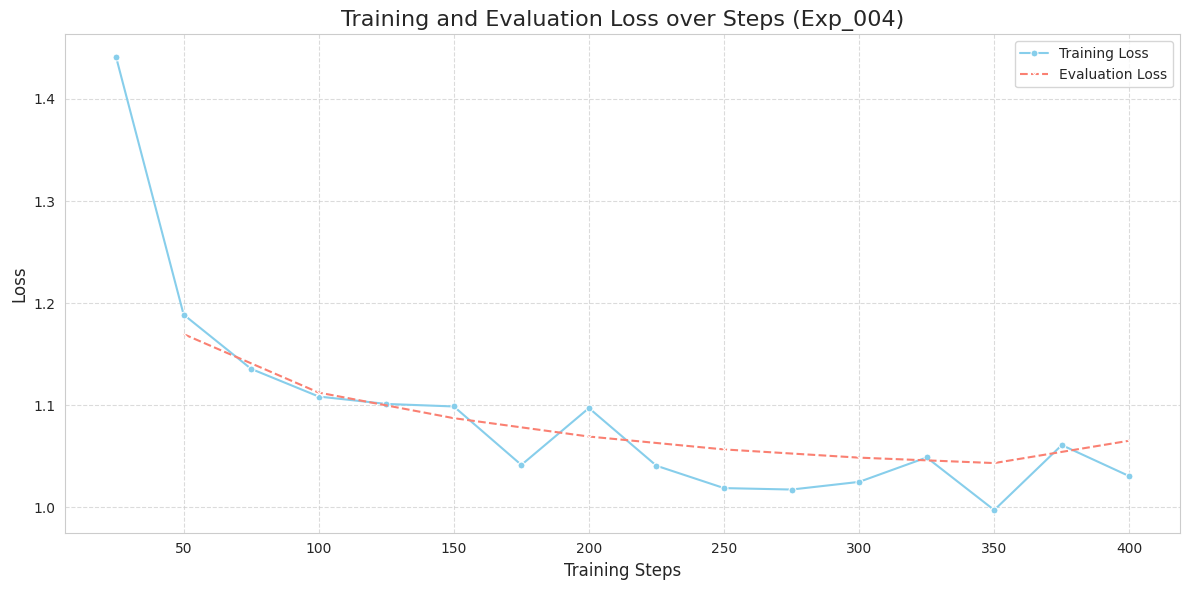

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

# Define the path to the trainer_state.json, looking within the latest checkpoint
# Assuming CHECKPOINT_DIR and the final checkpoint directory exist from previous steps
final_checkpoint_dir = os.path.join(CHECKPOINT_DIR, 'checkpoint-400') # Assuming 400 was the max_steps
trainer_state_path = os.path.join(final_checkpoint_dir, 'trainer_state.json')

# Load the training logs
training_logs = []
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)
        training_logs = trainer_state.get('log_history', [])
    print(f"Loaded training logs from: {trainer_state_path}")
else:
    print(f"Warning: trainer_state.json not found at {trainer_state_path}. Cannot plot training history.")

# Prepare data for plotting
plot_training_steps = []
plot_training_losses = []
plot_eval_steps = []
plot_eval_losses = []

for log in training_logs:
    if 'loss' in log and log['loss'] is not None: # Training loss
        plot_training_steps.append(log['step'])
        plot_training_losses.append(log['loss'])
    if 'eval_loss' in log and log['eval_loss'] is not None: # Evaluation loss
        plot_eval_steps.append(log['step'])
        plot_eval_losses.append(log['eval_loss'])


# Plotting
if plot_training_steps or plot_eval_steps:
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    if plot_training_steps:
        sns.lineplot(x=plot_training_steps, y=plot_training_losses, label='Training Loss', marker='o', markersize=5, linestyle='-', color='skyblue')
    if plot_eval_steps:
        sns.lineplot(x=plot_eval_steps, y=plot_eval_losses, label='Evaluation Loss', marker='x', markersize=5, linestyle='--', color='salmon')

    plt.title('Training and Evaluation Loss over Steps (Exp_004)', fontsize=16)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No valid training or evaluation loss data found in logs to plot.")


In [16]:
import pickle
import os

# 1. Access the 'test' split from the `train_val_test_dataset_cleaned` DatasetDict
# Assuming `train_val_test_dataset_cleaned` is available from the previous step
test_dataset_original = train_val_test_dataset_cleaned['test']
print(f"Loaded 'test' split with {len(test_dataset_original)} examples.")
print("Sample original test example:")
print(test_dataset_original[0])

# 2. Load the baseline responses from the file `/content/baseline_responses.pkl`
baseline_responses_path = '/content/baseline_responses.pkl'

if os.path.exists(baseline_responses_path):
    with open(baseline_responses_path, 'rb') as f:
        baseline_responses = pickle.load(f)
    print(f"Successfully loaded baseline responses from {baseline_responses_path}.")
    print(f"Number of baseline responses: {len(baseline_responses)}")
    print("Sample baseline response:")
    print(baseline_responses.iloc[0]) # Fixed: Use .iloc[0] for positional access
else:
    print(f"Error: Baseline responses file not found at {baseline_responses_path}.")
    baseline_responses = [] # Initialize as empty to prevent further errors

# 3. Verify that the number of baseline responses matches the number of examples in the 'test' split
if len(baseline_responses) == len(test_dataset_original):
    print("Verification successful: Number of baseline responses matches the test dataset size.")
else:
    print(f"Warning: Mismatch in count! Test dataset has {len(test_dataset_original)} examples, but baseline responses has {len(baseline_responses)}.")

Loaded 'test' split with 1812 examples.
Sample original test example:
{'instruction': 'What causes Prostate Enlargement: Benign Prostatic Hyperplasia ?', 'response': 'The cause of benign prostatic hyperplasia is not well understood; however, it occurs mainly in older men. Benign prostatic hyperplasia does not develop in men whose testicles were removed before puberty. For this reason, some researchers believe factors related to aging and the testicles may cause benign prostatic hyperplasia.\n                \nThroughout their lives, men produce testosterone, a male hormone, and small amounts of estrogen, a female hormone. As men age, the amount of active testosterone in their blood decreases, which leaves a higher proportion of estrogen. Scientific studies have suggested that benign prostatic hyperplasia may occur because the higher proportion of estrogen within the prostate increases the activity of substances that promote prostate cell growth.\n                \nAnother theory focuse

In [17]:
import pickle
import os
import pandas as pd
from datasets import Dataset, DatasetDict

# Assuming `train_val_test_dataset_cleaned` is available from the previous step

# 1. Access the 'test' split from the `train_val_test_dataset_cleaned` and convert it into a Pandas DataFrame
df_test_original = pd.DataFrame(train_val_test_dataset_cleaned['test'])
print(f"Loaded 'test' split into df_test_original with {len(df_test_original)} examples.")
print("Sample df_test_original example:\n", df_test_original.head(1).to_dict('records'))

# 2. Load the baseline responses from the file `/content/baseline_responses.pkl` into a Pandas DataFrame
baseline_responses_path = '/content/baseline_responses.pkl'

df_baseline_raw = pd.DataFrame()
if os.path.exists(baseline_responses_path):
    with open(baseline_responses_path, 'rb') as f:
        df_baseline_raw = pickle.load(f)
    print(f"\nSuccessfully loaded baseline responses from {baseline_responses_path} into df_baseline_raw.")
    print(f"Number of raw baseline responses: {len(df_baseline_raw)}")
    print("Sample df_baseline_raw example:\n", df_baseline_raw.head(1).to_dict('records'))
else:
    print(f"\nError: Baseline responses file not found at {baseline_responses_path}.")

# 3. Verify that df_baseline_raw contains unique 'instruction' entries and handle duplicates
initial_baseline_rows = len(df_baseline_raw)
df_baseline_raw = df_baseline_raw.drop_duplicates(subset=['instruction'], keep='first')
duplicates_removed = initial_baseline_rows - len(df_baseline_raw)
if duplicates_removed > 0:
    print(f"\nRemoved {duplicates_removed} duplicate instructions from df_baseline_raw.")
    print(f"Number of unique baseline instructions: {len(df_baseline_raw)}")

# 4. Perform an inner merge between df_test_original and df_baseline_raw on the 'instruction' column
# This ensures only instructions present in both are kept
df_aligned_data = pd.merge(
    df_test_original[['instruction', 'response']], # Only take 'instruction' and 'response' from original test set
    df_baseline_raw[['instruction', 'generated_response']], # Only take 'instruction' and 'generated_response' from baseline
    on='instruction',
    how='inner'
)

print(f"\nPerformed inner merge. Aligned dataset size: {len(df_aligned_data)}")

# 5. Verify that the number of entries in df_aligned_data matches the number of unique instructions after the merge
if len(df_aligned_data) != len(df_baseline_raw) or len(df_aligned_data) != len(df_test_original.drop_duplicates(subset=['instruction'])):
    print("Warning: Discrepancy in aligned data size or unique instruction count after merge.")

# 6. Extract the aligned original test data
test_dataset_aligned_df = df_aligned_data[['instruction', 'response']].copy()

# 7. Extract the aligned baseline responses
baseline_responses_aligned_df = df_aligned_data[['instruction', 'generated_response']].copy()

# 8. Print the lengths and display samples to verify
print(f"\nLength of test_dataset_aligned_df: {len(test_dataset_aligned_df)}")
print(f"Length of baseline_responses_aligned_df: {len(baseline_responses_aligned_df)}")

if len(test_dataset_aligned_df) == len(baseline_responses_aligned_df):
    print("Verification successful: Aligned datasets have matching lengths.")
else:
    print("Verification failed: Aligned datasets have different lengths.")

print("\nSample from test_dataset_aligned_df:")
print(test_dataset_aligned_df.head(1).to_dict('records'))

print("\nSample from baseline_responses_aligned_df:")
print(baseline_responses_aligned_df.head(1).to_dict('records'))

Loaded 'test' split into df_test_original with 1812 examples.
Sample df_test_original example:
 [{'instruction': 'What causes Prostate Enlargement: Benign Prostatic Hyperplasia ?', 'response': 'The cause of benign prostatic hyperplasia is not well understood; however, it occurs mainly in older men. Benign prostatic hyperplasia does not develop in men whose testicles were removed before puberty. For this reason, some researchers believe factors related to aging and the testicles may cause benign prostatic hyperplasia.\n                \nThroughout their lives, men produce testosterone, a male hormone, and small amounts of estrogen, a female hormone. As men age, the amount of active testosterone in their blood decreases, which leaves a higher proportion of estrogen. Scientific studies have suggested that benign prostatic hyperplasia may occur because the higher proportion of estrogen within the prostate increases the activity of substances that promote prostate cell growth.\n            

In [18]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

# 1. Define the base model name
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# 2. Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for model loading: {device}")

# 3. Load the base AutoModelForCausalLM
base_model = None
if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load base model with 4-bit quantization.")
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        base_model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=quantization_config,
            dtype=torch.bfloat16,
            device_map="auto"
        )
        print("Base model loaded successfully with 4-bit quantization.")
    except Exception as e:
        print(f"Warning: 4-bit quantization failed during base model load ({e}). Falling back to loading base model in full bfloat16 precision.")
        base_model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            dtype=torch.bfloat16,
            device_map="auto"
        )
else:
    print("CUDA not available. Loading base model in full float32 precision.")
    base_model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        dtype=torch.float32,
        device_map="auto"
    )

# 4. Ensure model.config.use_cache = False
base_model.config.use_cache = False
print("Set base_model.config.use_cache = False.")

# 5. Load the fine-tuned LoRA adapters
# FINAL_ADAPTER_DIR is expected to be available from previous steps
if 'FINAL_ADAPTER_DIR' in globals() and os.path.exists(FINAL_ADAPTER_DIR):
    fine_tuned_model = PeftModel.from_pretrained(base_model, FINAL_ADAPTER_DIR)
    print(f"Fine-tuned PEFT model loaded successfully from {FINAL_ADAPTER_DIR}")
else:
    print(f"Error: FINAL_ADAPTER_DIR not found or not defined. Expected: {FINAL_ADAPTER_DIR}")
    fine_tuned_model = None # Ensure fine_tuned_model is defined even if not loaded

# 6. Print confirmation message
if base_model is not None and fine_tuned_model is not None:
    print("Both base model and fine-tuned PEFT model are loaded.")
elif base_model is not None:
    print("Base model loaded, but fine-tuned model could not be loaded.")
else:
    print("Failed to load base model.")

Using device for model loading: cuda
Attempting to load base model with 4-bit quantization.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model loaded successfully with 4-bit quantization.
Set base_model.config.use_cache = False.
Fine-tuned PEFT model loaded successfully from /content/drive/MyDrive/llm_checkpoints 4/exp_004/final_lora_adapters
Both base model and fine-tuned PEFT model are loaded.


## Generate Fine-tuned Model Responses in Batches


In [20]:
import torch

# Ensure tokenizer is available from previous steps
# Ensure fine_tuned_model is available from previous steps
# Ensure test_dataset_aligned_df is available from previous steps

# 1. Initialize an empty list named `fine_tuned_generated_responses`
fine_tuned_generated_responses = []

# 2. Define a BATCH_SIZE variable
BATCH_SIZE = 16

print(f"Generating responses for the fine-tuned model in batches of {BATCH_SIZE}...")

# 3. Iterate through the `test_dataset_aligned_df` DataFrame in chunks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(0, len(test_dataset_aligned_df), BATCH_SIZE):
    end_idx = min(i + BATCH_SIZE, len(test_dataset_aligned_df))
    batch_df = test_dataset_aligned_df.iloc[i:end_idx]

    # a. Extract the `instruction` column for the current batch
    batch_instructions = batch_df['instruction'].tolist()

    # b. Create a list of `batch_prompts`
    batch_prompts = [f"""### Instruction:\n{instruction}\n\n### Response:""" for instruction in batch_instructions]

    # c. Tokenize the `batch_prompts`
    inputs = tokenizer(
        batch_prompts,
        padding=True,
        truncation=True,
        max_length=512, # Using a fixed reasonable length as suggested
        return_tensors="pt"
    ).to(device)

    # d. Call the `fine_tuned_model.generate()` method
    generated_ids = fine_tuned_model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    # e. Decode the `generated_ids` for the entire batch
    decoded_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    # f. For each `decoded_text` in the batch:
    for decoded_text in decoded_texts:
        # i. Find the starting index of '### Response:'
        response_start_index = decoded_text.find("### Response:")
        if response_start_index != -1:
            # ii. Extract and strip the response content
            response_content = decoded_text[response_start_index + len("### Response:"):]
            cleaned_response = response_content.strip()
        else:
            # If '### Response:' is not found, return the full generated text or an empty string
            cleaned_response = decoded_text.strip() # Fallback, though ideally it should follow the format

        # iii. Append this cleaned generated response to the `fine_tuned_generated_responses` list
        fine_tuned_generated_responses.append(cleaned_response)

# 5. Add this list as a new column named 'fine_tuned_generated_response' to the `test_dataset_aligned_df` DataFrame
test_dataset_aligned_df['fine_tuned_generated_response'] = fine_tuned_generated_responses

print("Fine-tuned model responses generated and added to `test_dataset_aligned_df`.")
print("Sample of `test_dataset_aligned_df` with generated responses (first 5 rows):")
print(test_dataset_aligned_df[['instruction', 'response', 'fine_tuned_generated_response']].head().to_markdown(index=False))

Generating responses for the fine-tuned model in batches of 16...
Fine-tuned model responses generated and added to `test_dataset_aligned_df`.
Sample of `test_dataset_aligned_df` with generated responses (first 5 rows):
| instruction                                                      | response                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [22]:
!pip install -qqq evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00


In [24]:
pip install -qqq rouge_score

  Preparing metadata (setup.py) ... done


In [26]:
pip install -qqq bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.6 MB/s eta 0:00:00


In [27]:
import evaluate
import pandas as pd
import numpy as np # For averaging BERTScore results

# Assuming test_dataset_aligned_df and baseline_responses_aligned_df are available

# 2. Extract ground truth responses
references = test_dataset_aligned_df['response'].tolist()

# 3. Extract fine-tuned model's generated responses
predictions_finetuned = test_dataset_aligned_df['fine_tuned_generated_response'].tolist()

# 4. Extract baseline model's generated responses
predictions_baseline = baseline_responses_aligned_df['generated_response'].tolist()

print(f"Number of references: {len(references)}")
print(f"Number of fine-tuned predictions: {len(predictions_finetuned)}")
print(f"Number of baseline predictions: {len(predictions_baseline)}")

# 5. Load the 'rouge' metric
rouge = evaluate.load('rouge')
print("ROUGE metric loaded.")

# 6. Load the 'bleu' metric
bleu = evaluate.load('bleu')
print("BLEU metric loaded.")

# 7. Load the 'bertscore' metric
bertscore = evaluate.load('bertscore')
print("BERTScore metric loaded.")

evaluation_results = {}

# 8. Calculate ROUGE scores for the fine-tuned model
print("Calculating ROUGE for fine-tuned model...")
rouge_finetuned = rouge.compute(predictions=predictions_finetuned, references=references)
evaluation_results['rouge_finetuned'] = rouge_finetuned
print("ROUGE for fine-tuned model computed.")

# 9. Calculate ROUGE scores for the baseline model
print("Calculating ROUGE for baseline model...")
rouge_baseline = rouge.compute(predictions=predictions_baseline, references=references)
evaluation_results['rouge_baseline'] = rouge_baseline
print("ROUGE for baseline model computed.")

# 10. Calculate BLEU scores for the fine-tuned model
print("Calculating BLEU for fine-tuned model...")
bleu_finetuned = bleu.compute(predictions=predictions_finetuned, references=references)
evaluation_results['bleu_finetuned'] = bleu_finetuned
print("BLEU for fine-tuned model computed.")

# 11. Calculate BLEU scores for the baseline model
print("Calculating BLEU for baseline model...")
bleu_baseline = bleu.compute(predictions=predictions_baseline, references=references)
evaluation_results['bleu_baseline'] = bleu_baseline
print("BLEU for baseline model computed.")

# 12. Calculate BERTScore scores for the fine-tuned model
print("Calculating BERTScore for fine-tuned model (this may take a while)...")
bertscore_finetuned = bertscore.compute(predictions=predictions_finetuned, references=references, lang='en')
# Average BERTScore metrics for simplicity in storing
evaluation_results['bertscore_finetuned'] = {
    'precision': np.mean(bertscore_finetuned['precision']),
    'recall': np.mean(bertscore_finetuned['recall']),
    'f1': np.mean(bertscore_finetuned['f1'])
}
print("BERTScore for fine-tuned model computed.")

# 13. Calculate BERTScore scores for the baseline model
print("Calculating BERTScore for baseline model (this may take a while)...")
bertscore_baseline = bertscore.compute(predictions=predictions_baseline, references=references, lang='en')
# Average BERTScore metrics for simplicity in storing
evaluation_results['bertscore_baseline'] = {
    'precision': np.mean(bertscore_baseline['precision']),
    'recall': np.mean(bertscore_baseline['recall']),
    'f1': np.mean(bertscore_baseline['f1'])
}
print("BERTScore for baseline model computed.")

# 14. Print the collected evaluation results
print("\nEvaluation results:")
for metric_name, scores in evaluation_results.items():
    print(f"  {metric_name}: {scores}")

Number of references: 295
Number of fine-tuned predictions: 295
Number of baseline predictions: 295
ROUGE metric loaded.


BLEU metric loaded.


BERTScore metric loaded.
Calculating ROUGE for fine-tuned model...
ROUGE for fine-tuned model computed.
Calculating ROUGE for baseline model...
ROUGE for baseline model computed.
Calculating BLEU for fine-tuned model...
BLEU for fine-tuned model computed.
Calculating BLEU for baseline model...
BLEU for baseline model computed.
Calculating BERTScore for fine-tuned model (this may take a while)...


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
pooler.dense.weight             | MISSING    | 
pooler.dense.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


BERTScore for fine-tuned model computed.
Calculating BERTScore for baseline model (this may take a while)...
BERTScore for baseline model computed.

Evaluation results:
  rouge_finetuned: {'rouge1': np.float64(0.3120282031255576), 'rouge2': np.float64(0.12677174395974777), 'rougeL': np.float64(0.2043461812617478), 'rougeLsum': np.float64(0.217441375265434)}
  rouge_baseline: {'rouge1': np.float64(0.2686516894497142), 'rouge2': np.float64(0.07728583590716885), 'rougeL': np.float64(0.16906307855516772), 'rougeLsum': np.float64(0.18344683584050853)}
  bleu_finetuned: {'bleu': 0.09508469691486415, 'precisions': [0.36923076923076925, 0.149941611521993, 0.08986982480180092, 0.07066351644024414], 'brevity_penalty': 0.6943897900164321, 'length_ratio': 0.732750063809875, 'translation_length': 51675, 'reference_length': 70522}
  bleu_baseline: {'bleu': 0.029412205804006997, 'precisions': [0.3536300927993648, 0.09190891593971055, 0.03162771958098308, 0.01461298424537636], 'brevity_penalty': 0.472

In [28]:
import pandas as pd

# Assuming evaluation_results dictionary is available from the previous step

# Create a dictionary to hold the data for the DataFrame
data = {
    'Metric': [],
    'Fine-tuned Model': [],
    'Baseline Model': []
}

# Populate data for ROUGE scores
for key in ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']:
    data['Metric'].append(f'ROUGE-{key}')
    data['Fine-tuned Model'].append(evaluation_results['rouge_finetuned'][key])
    data['Baseline Model'].append(evaluation_results['rouge_baseline'][key])

# Populate data for BLEU score
data['Metric'].append('BLEU')
data['Fine-tuned Model'].append(evaluation_results['bleu_finetuned']['bleu'])
data['Baseline Model'].append(evaluation_results['bleu_baseline']['bleu'])

# Populate data for BERTScore metrics
for key in ['precision', 'recall', 'f1']:
    data['Metric'].append(f'BERTScore-{key}')
    data['Fine-tuned Model'].append(evaluation_results['bertscore_finetuned'][key])
    data['Baseline Model'].append(evaluation_results['bertscore_baseline'][key])

# Create the DataFrame
comparison_df = pd.DataFrame(data)

# Display the comparison DataFrame
print("\n--- Evaluation Metrics Comparison ---")
print(comparison_df.to_markdown(index=False))



--- Evaluation Metrics Comparison ---
| Metric              |   Fine-tuned Model |   Baseline Model |
|:--------------------|-------------------:|-----------------:|
| ROUGE-rouge1        |          0.312028  |        0.268652  |
| ROUGE-rouge2        |          0.126772  |        0.0772858 |
| ROUGE-rougeL        |          0.204346  |        0.169063  |
| ROUGE-rougeLsum     |          0.217441  |        0.183447  |
| BLEU                |          0.0950847 |        0.0294122 |
| BERTScore-precision |          0.841433  |        0.850867  |
| BERTScore-recall    |          0.85246   |        0.830268  |
| BERTScore-f1        |          0.846193  |        0.839922  |


## Visualize Metric Comparison


/tmp/ipython-input-378327559.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=scores, palette=colors, ax=ax)
/tmp/ipython-input-378327559.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=scores, palette=colors, ax=ax)
/tmp/ipython-input-378327559.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=scores, palette=colors, ax=ax)
/tmp/ipython-input-378327559.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` v

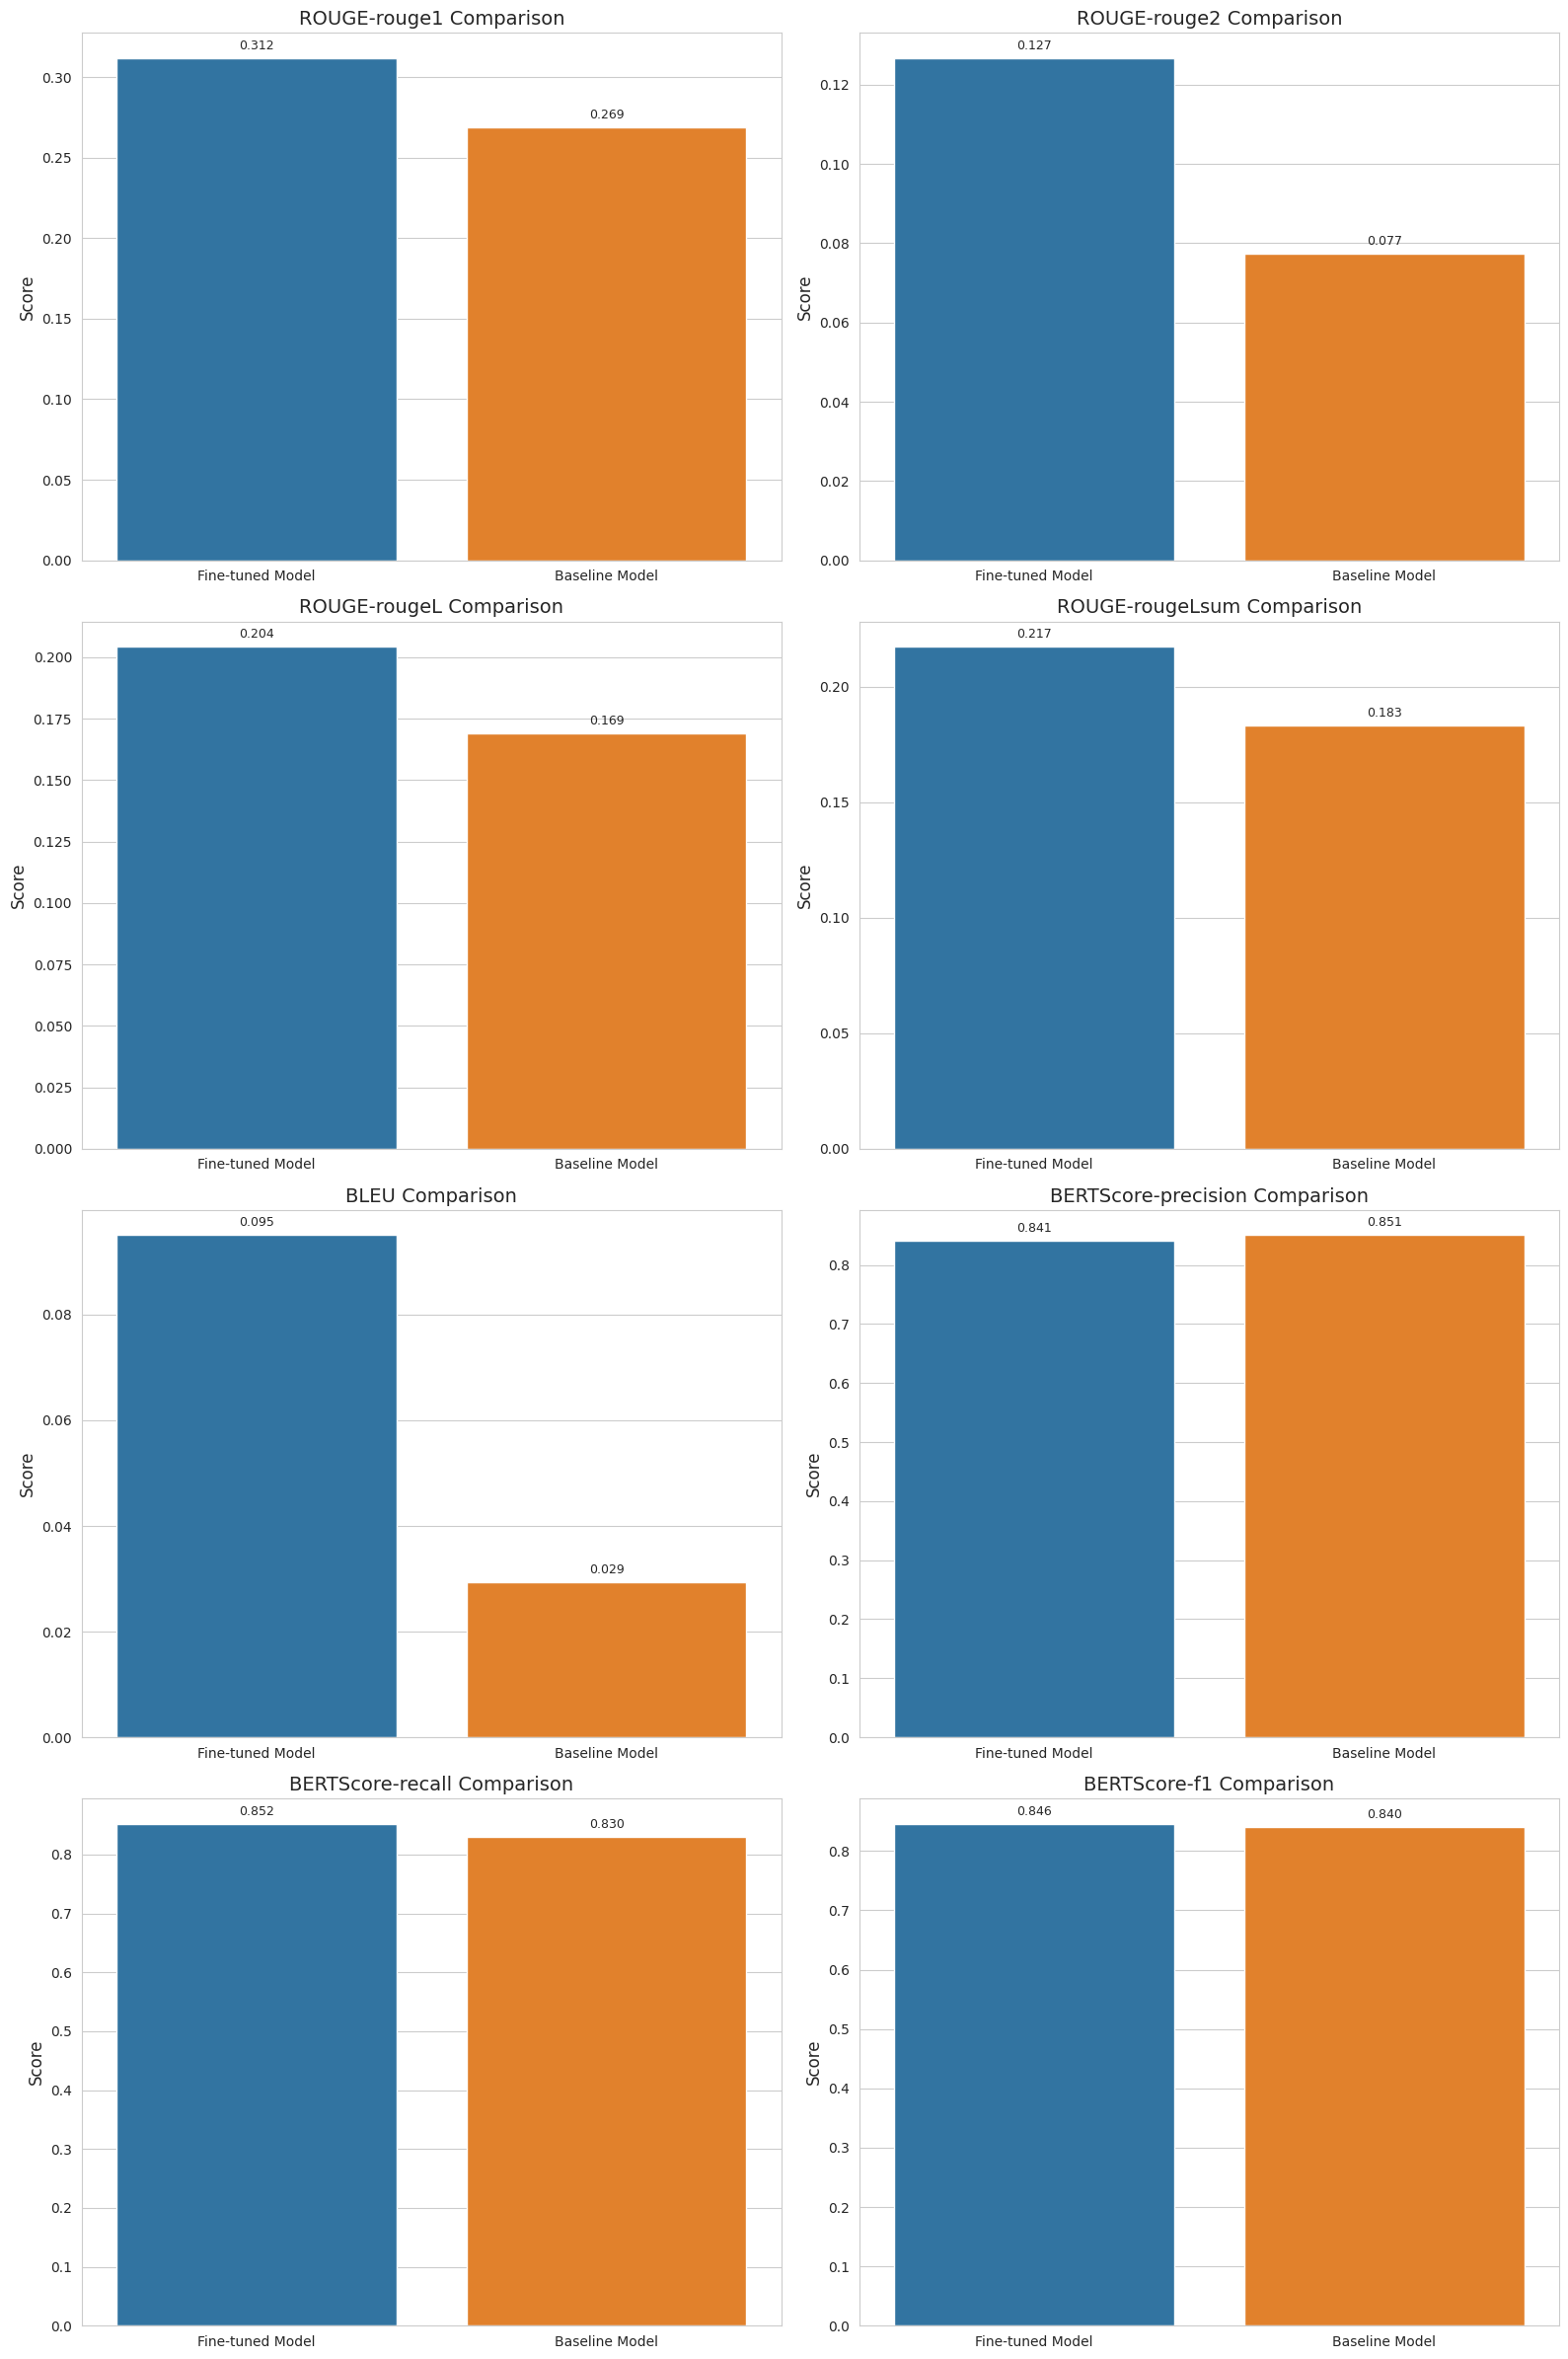

Visualizations of metric comparisons generated successfully.


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For handling potential numpy float types from comparison_df

# Assuming comparison_df is available from the previous step

# 1. Prepare data for plotting
metrics = comparison_df['Metric'].tolist()
fine_tuned_scores = comparison_df['Fine-tuned Model'].tolist()
baseline_scores = comparison_df['Baseline Model'].tolist()

# 2. Create subplots for each metric
# There are 8 metrics, so 4 rows and 2 columns would be suitable
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Define colors for clarity
colors = ['#1f77b4', '#ff7f0e'] # Blue for fine-tuned, Orange for baseline

# 3. Iterate through each metric and create a bar chart
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Data for the current metric
    scores = [fine_tuned_scores[i], baseline_scores[i]]
    model_names = ['Fine-tuned Model', 'Baseline Model']

    # Ensure scores are float for plotting
    scores = [float(s) if isinstance(s, np.floating) else s for s in scores]

    sns.barplot(x=model_names, y=scores, palette=colors, ax=ax)

    ax.set_title(f'{metric} Comparison', fontsize=14)
    ax.set_ylabel('Score', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # Add value labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=9)

# 4. Adjust layout and display the plots
plt.tight_layout()
plt.show()

print("Visualizations of metric comparisons generated successfully.")

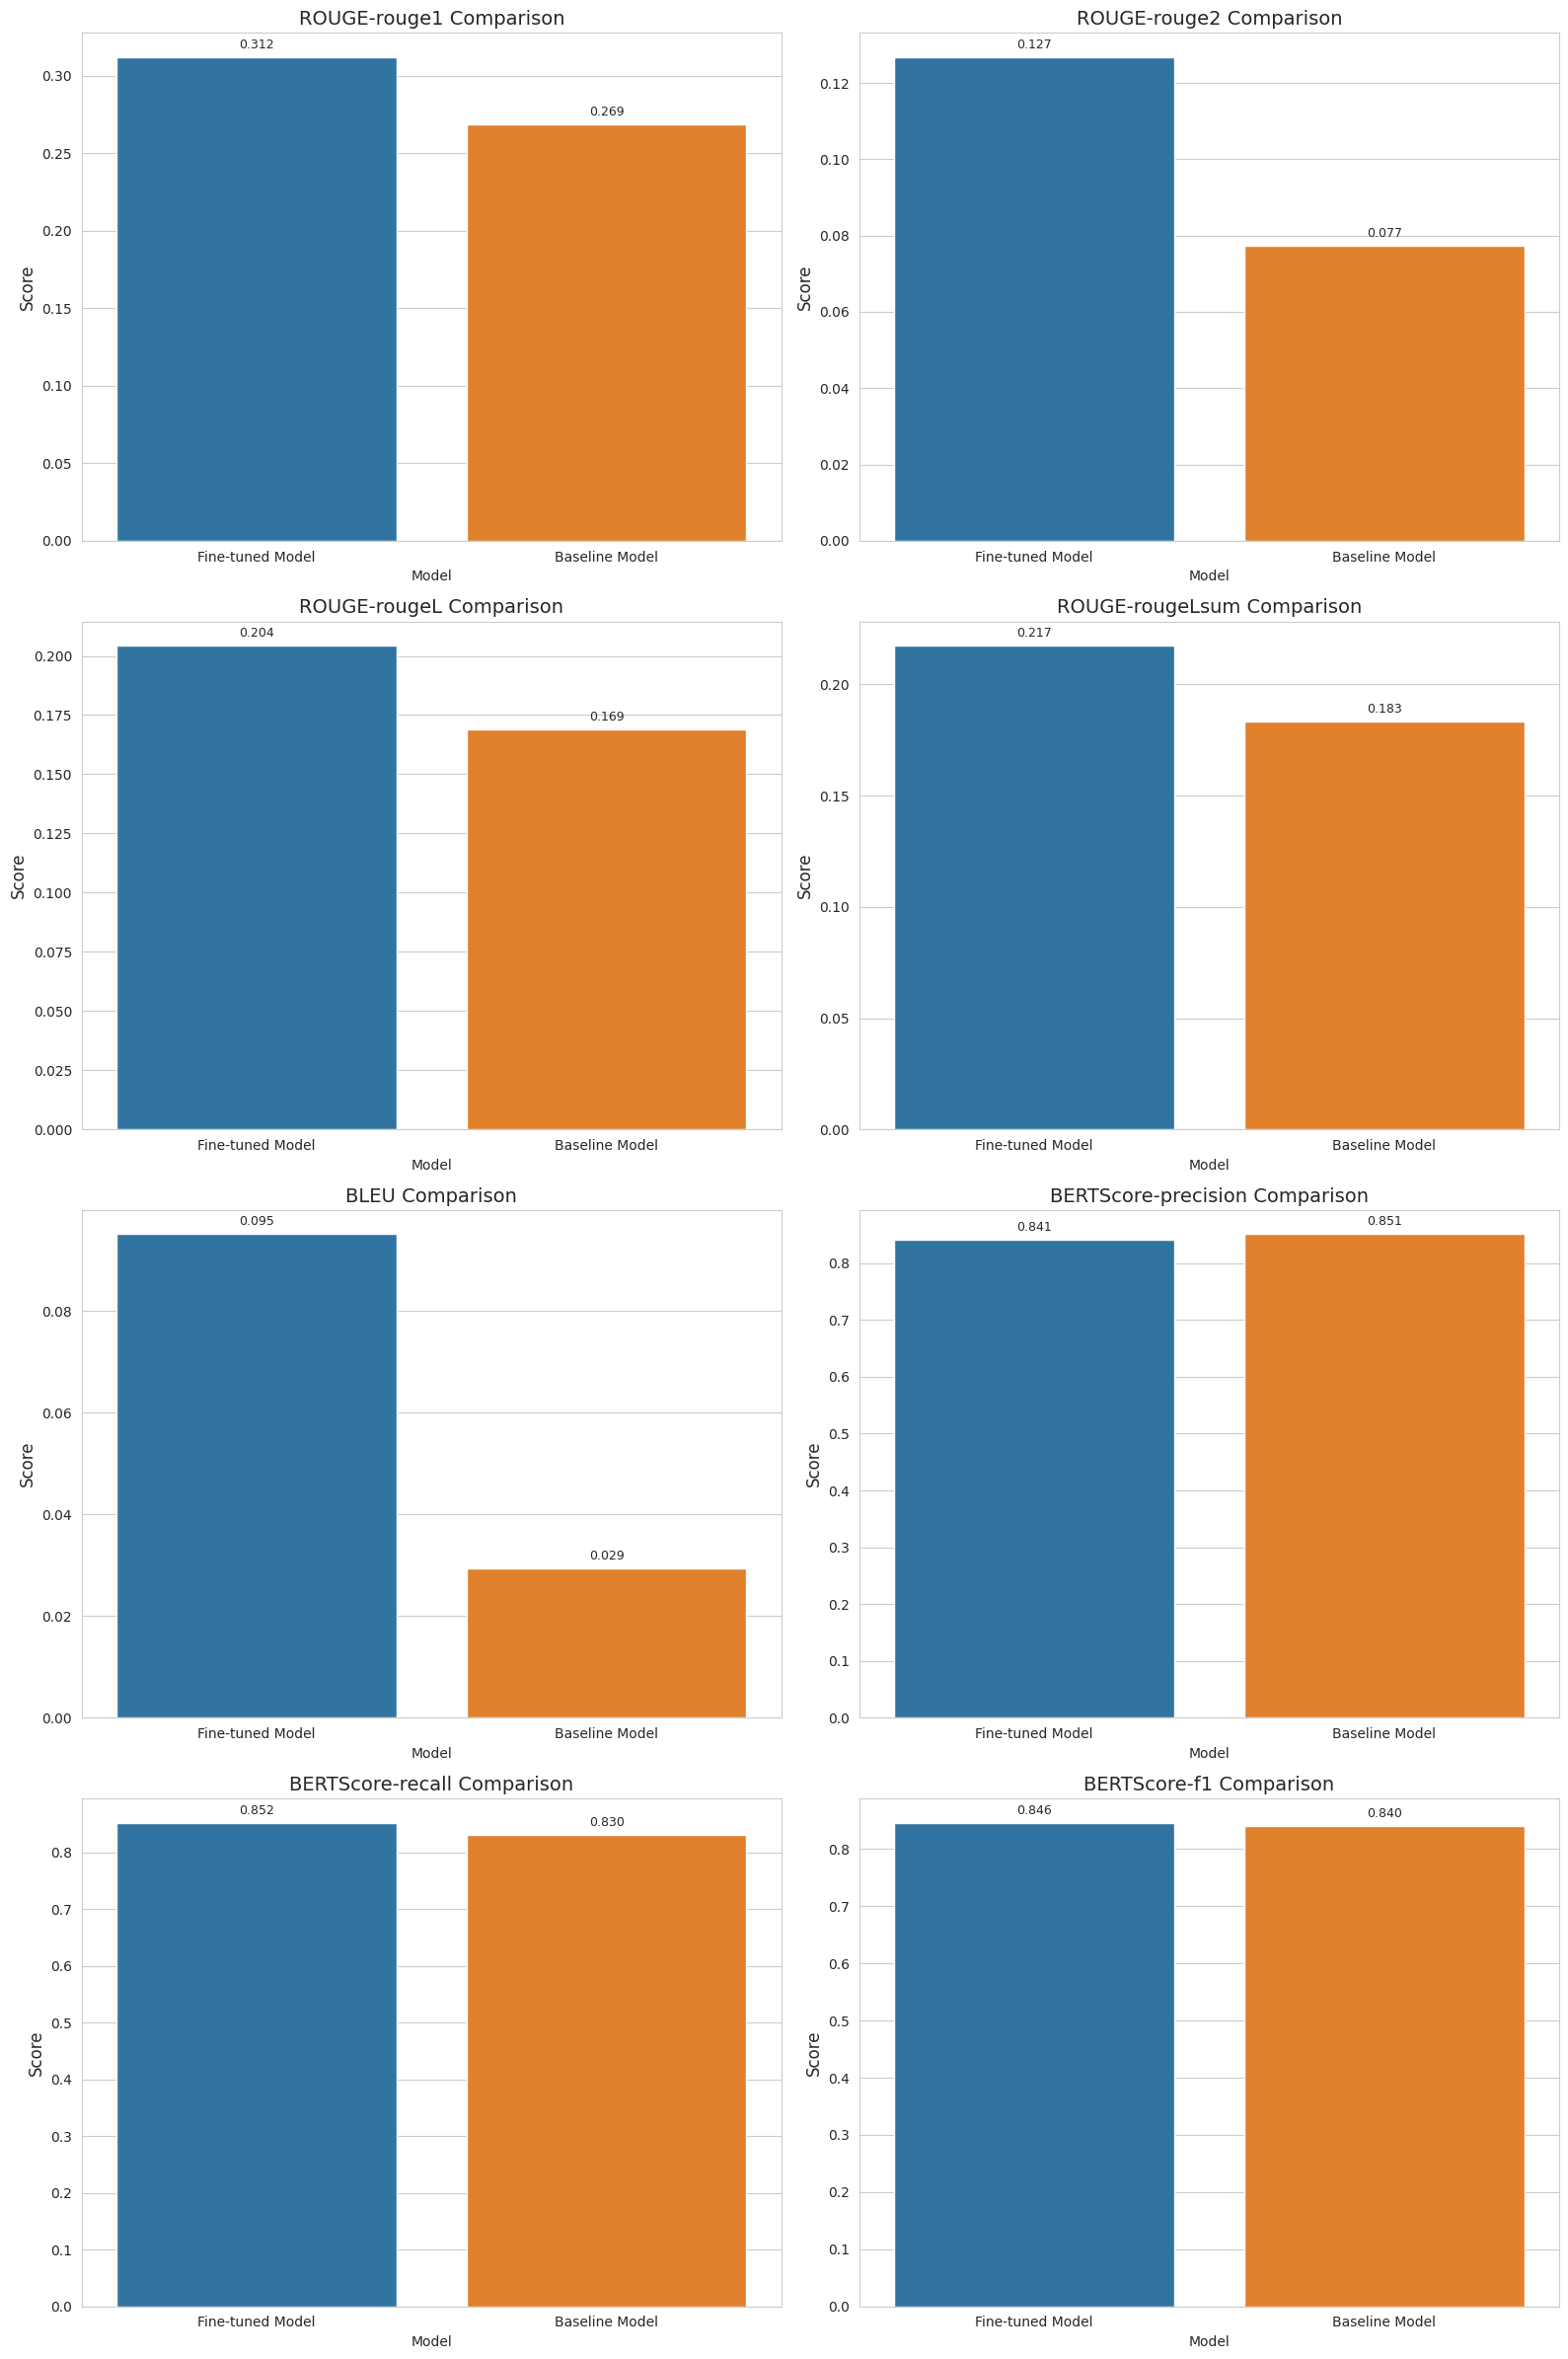

Visualizations of metric comparisons generated successfully.


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For handling potential numpy float types from comparison_df
import pandas as pd # Import pandas for temporary DataFrame creation

# Assuming comparison_df is available from the previous step

# 1. Prepare data for plotting
metrics = comparison_df['Metric'].tolist()
fine_tuned_scores = comparison_df['Fine-tuned Model'].tolist()
baseline_scores = comparison_df['Baseline Model'].tolist()

# 2. Create subplots for each metric
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Define colors for clarity
colors = ['#1f77b4', '#ff7f0e'] # Blue for fine-tuned, Orange for baseline

# 3. Iterate through each metric and create a bar chart
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Data for the current metric
    scores_data = {
        'Model': ['Fine-tuned Model', 'Baseline Model'],
        'Score': [float(fine_tuned_scores[i]), float(baseline_scores[i])] # Ensure scores are float
    }
    temp_df = pd.DataFrame(scores_data)

    # Use hue for explicit coloring and legend control as per FutureWarning suggestion
    sns.barplot(x='Model', y='Score', hue='Model', data=temp_df, palette=colors, ax=ax, legend=False)

    ax.set_title(f'{metric} Comparison', fontsize=14)
    ax.set_ylabel('Score', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # Add value labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=9)

# 4. Adjust layout and display the plots
plt.tight_layout()
plt.show()

print("Visualizations of metric comparisons generated successfully.")

In [32]:
from google.colab import userdata
from huggingface_hub import login
import os

# Retrieve Hugging Face token from secrets
HF_TOKEN = userdata.get('HF_TOKEN')

# Log in to Hugging Face
login(token=HF_TOKEN, add_to_git_credential=True)
print("Logged in to Hugging Face.")

# Define the repository name on Hugging Face Hub
hf_username = "Jeanrobert"
repo_id = f"{hf_username}/TinyLlama-1.1B-Chat-v1.0-Exp_004"

# Push the fine-tuned PEFT model to Hugging Face Hub
print(f"\nPushing fine-tuned model to Hugging Face Hub: {repo_id}...")
peft_model.push_to_hub(repo_id)
print("Fine-tuned PEFT model pushed successfully.")

# Push the tokenizer to Hugging Face Hub
print("\nPushing tokenizer to Hugging Face Hub...")
tokenizer.push_to_hub(repo_id)
print("Tokenizer pushed successfully.")

print("\nBoth fine-tuned model and tokenizer have been uploaded to Hugging Face.")

Logged in to Hugging Face.

Pushing fine-tuned model to Hugging Face Hub: Jeanrobert/TinyLlama-1.1B-Chat-v1.0-Exp_004...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   2%|2         |  562kB / 25.3MB            

Fine-tuned PEFT model pushed successfully.

Pushing tokenizer to Hugging Face Hub...


README.md: 0.00B [00:00, ?B/s]

Tokenizer pushed successfully.

Both fine-tuned model and tokenizer have been uploaded to Hugging Face.
